# Polypropylene vs Upstream Drivers: Exploratory Data Analysis

Explore whether PP prices co-move with propylene (PGP) and crude; establish sensible baselines before expanding into richer feature sets.

Local files under `data/` are used throughout. Units, currencies, and frequencies may differ, so we normalize and resample to monthly for comparability.

In [ ]:
#pip install -q pandas numpy matplotlib seaborn statsmodels

In [2]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data"
PLOTS_DIR = PROJECT_DIR / "plots"
ARTIFACTS_DIR = PROJECT_DIR / "artifacts"
for folder in (PLOTS_DIR, ARTIFACTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(PROJECT_DIR / "src"))
from eda_utils import (
    build_audit_table,
    compute_log_returns,
    cross_corr_scan,
    find_candidate_files,
    load_series,
    normalize_base_100,
    plot_beta_scaled_spread,
    plot_leadlag_heatmap,
    plot_normalized_levels,
    plot_rolling_beta,
    plot_scatter_returns,
    rolling_beta_ols,
    rolling_corr,
    to_monthly,
)

plt.rcParams["figure.dpi"] = 150
CLASS_KEYWORDS = {
    "PP": ["pp", "polypropylene"],
    "PGP": ["pgp", "propylene", "c3"],
    "CRUDE": ["brent", "wti", "crude", "oil"],
    "NAPHTHA": ["naphtha"],
}


## Discovery & loading

Find candidate files by keyword, load each series with `eda_utils.load_series`, and capture metadata for traceability.

In [3]:
candidate_map = {
    label: find_candidate_files(DATA_DIR, patterns)
    for label, patterns in CLASS_KEYWORDS.items()
}

loaded_series = {}
discovery_records = []
for label, paths in candidate_map.items():
    if not paths:
        print(
            f"No {label} series found. Expected keywords: {CLASS_KEYWORDS[label]}"
        )
        continue
    series_list = []
    for path in paths:
        try:
            df = load_series(path, f"{label}|{path.stem}")
        except Exception as exc:
            print(f"Skipping {path.name}: {exc}")
            continue
        series_list.append(df)
        discovery_records.append(
            {
                "class": label,
                "series_name": df.attrs.get("series_name"),
                "file": path.relative_to(PROJECT_DIR),
                "date_column": df.attrs.get("date_column"),
                "value_column": df.attrs.get("value_column"),
                "rows_raw": df.attrs.get("rows_raw"),
                "rows_clean": df.attrs.get("rows_clean"),
                "start": df.attrs.get("start"),
                "end": df.attrs.get("end"),
            }
        )
    if series_list:
        loaded_series[label] = series_list
discovery_df = pd.DataFrame(discovery_records)
if not discovery_df.empty:
    display(discovery_df)
else:
    display(Markdown("**No qualifying series loaded — add data to proceed.**"))


No NAPHTHA series found. Expected keywords: ['naphtha']


,class,series_name,file,date_column,value_column,rows_raw,rows_clean,start,end
0,PP,PP|polypropylene_primary_avg_prices,data\prices\polypropylene_primary_avg_prices.csv,Date,PP_Avg_EUR_per_t,81,81,2018-08-01,2025-04-01
1,PP,PP|polypropylene_weekly,data\prices\polypropylene_weekly.csv,Date,Price,520,520,2015-01-04,2025-03-02
2,PP,PP|polypropylene_weekly_clean,data\prices\polypropylene_weekly_clean.csv,date,price,520,520,2015-01-04,2025-03-02
3,PGP,PGP|polypropylene_primary_avg_prices,data\prices\polypropylene_primary_avg_prices.csv,Date,PP_Avg_EUR_per_t,81,81,2018-08-01,2025-04-01
4,PGP,PGP|polypropylene_weekly,data\prices\polypropylene_weekly.csv,Date,Price,520,520,2015-01-04,2025-03-02
5,PGP,PGP|polypropylene_weekly_clean,data\prices\polypropylene_weekly_clean.csv,date,price,520,520,2015-01-04,2025-03-02
6,CRUDE,CRUDE|crude_oil_daily,data\prices\crude_oil_daily.csv,Date,Close,5426,2712,2015-01-02,2025-10-14
7,CRUDE,CRUDE|crude_oil_weekly,data\prices\crude_oil_weekly.csv,Date,Close,1129,564,2015-01-05,2025-10-20
8,CRUDE,CRUDE|crude_oil_weekly_clean,data\prices\crude_oil_weekly_clean.csv,Date,Close,1128,1128,2015-01-05,2025-10-20


_Table note:_ The discovery summary above lists every file that matched our keyword scan and highlights which date/value columns were inferred so you can quickly spot mislabelled sources.

## Monthly alignment

Resample each raw series to monthly means, keep one preferred series per class, and form wide outer/inner tables.

In [4]:
monthly_tables = {}
preferred = {}
for label, series_list in loaded_series.items():
    monthly_list = [to_monthly(series) for series in series_list]
    table = pd.concat(monthly_list, axis=1)
    table = table.loc[~table.index.duplicated()].sort_index()
    monthly_tables[label] = table
    preferred_series_name = table.count().sort_values(ascending=False).index[0]
    preferred[label] = table[preferred_series_name]
wide_outer = pd.concat(monthly_tables.values(), axis=1) if monthly_tables else pd.DataFrame()
monthly_inner = pd.concat(preferred, axis=1).dropna() if preferred else pd.DataFrame()
display(Markdown(f"**Monthly outer shape:** {wide_outer.shape}"))
display(Markdown(f"**Monthly inner shape:** {monthly_inner.shape}"))
wide_outer.head()


**Monthly outer shape:** (130, 9)

**Monthly inner shape:** (123, 3)

,PP|polypropylene_primary_avg_prices,PP|polypropylene_weekly,PP|polypropylene_weekly_clean,PGP|polypropylene_primary_avg_prices,PGP|polypropylene_weekly,PGP|polypropylene_weekly_clean,CRUDE|crude_oil_daily,CRUDE|crude_oil_weekly,CRUDE|crude_oil_weekly_clean
2015-01-01,NaN,8285.25,8285.25,NaN,8285.25,8285.25,47.325500,48.224125,49.246187
2015-02-01,NaN,8748.00,8748.00,NaN,8748.00,8748.00,50.724736,49.986625,53.093875
2015-03-01,NaN,8829.40,8829.40,NaN,8829.40,8829.40,47.854091,48.135600,52.875400
2015-04-01,NaN,9348.00,9348.00,NaN,9348.00,9348.00,54.628096,53.463125,56.592562
2015-05-01,NaN,9142.00,9142.00,NaN,9142.00,9142.00,59.372000,59.418000,62.724000


In [5]:
audit_input = {label: series for label, series in preferred.items()}
audit_table = build_audit_table(audit_input) if audit_input else pd.DataFrame()
if not audit_table.empty:
    display(audit_table)
    audit_table.to_csv(ARTIFACTS_DIR / "data_audit.csv", index=False)
monthly_inner.to_csv(ARTIFACTS_DIR / "merged_monthly_prices.csv")


,series,first_date,last_date,count,missing_pct,frequency_note,currency,unit,source_path
0,PP,2015-01-01,2025-03-01,123,0.0,monthly (resampled via mean),None,None,None
1,PGP,2015-01-01,2025-03-01,123,0.0,monthly (resampled via mean),None,None,None
2,CRUDE,2015-01-01,2025-10-01,130,0.0,monthly (resampled via mean),None,None,None


_Audit note:_ Use the audit table to confirm coverage (first/last date, missing %), plus currency/unit hints pulled from the raw files.

## Levels (normalized)

Normalize each preferred level series to 100 at the first common observation.

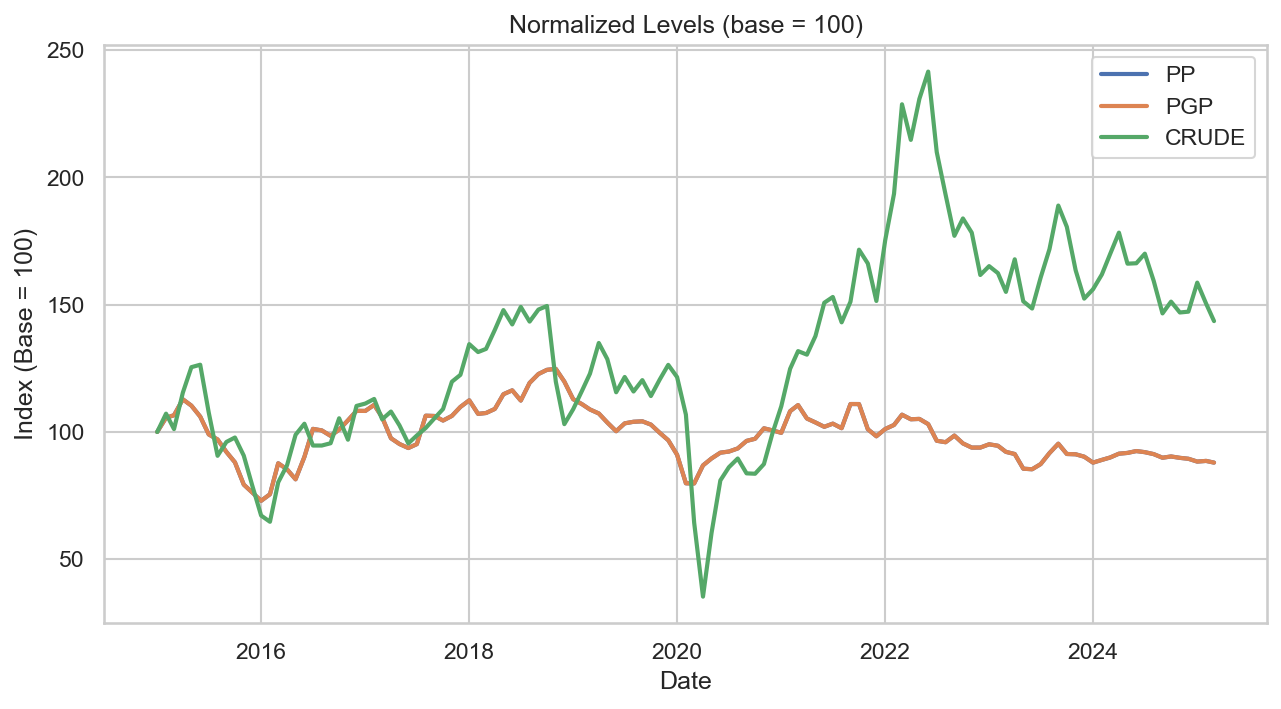

In [6]:
if not monthly_inner.empty:
    norm_levels = normalize_base_100(monthly_inner)
    fig = plot_normalized_levels(norm_levels, "Normalized Levels (base = 100)")
    display(fig)
    fig.savefig(PLOTS_DIR / "levels_normalized.png", bbox_inches="tight")
    plt.close(fig)
else:
    display(Markdown("*No overlapping monthly series available.*"))


_Figure:_ Normalized level lines let us compare PP and crude trends on a common 100-base scale so different currencies/units do not mask co-movement.

## Returns & correlations

Compute log returns, save clean datasets, and prepare diagnostics for PP vs key drivers.

In [7]:
if not monthly_inner.empty:
    log_returns = compute_log_returns(monthly_inner).dropna()
    log_returns.to_csv(ARTIFACTS_DIR / "merged_monthly_returns.csv")
    display(log_returns.describe().T)
else:
    log_returns = pd.DataFrame()
    display(Markdown("*Returns unavailable; add overlapping series.*"))


,count,mean,std,min,25%,50%,75%,max
PP,122.0,-0.001052,0.042444,-0.131583,-0.023175,-0.001969,0.020649,0.149596
PGP,122.0,-0.001052,0.042444,-0.131583,-0.023175,-0.001969,0.020649,0.149596
CRUDE,122.0,0.002964,0.120098,-0.600585,-0.053332,0.019625,0.056092,0.535517


_Table detail:_ The return summary offers mean/volatility/skewness for each monthly log-return series so you can judge distribution shape before modelling.

## Headline visuals

Key diagnostics for PP versus crude oil (or other drivers when available).

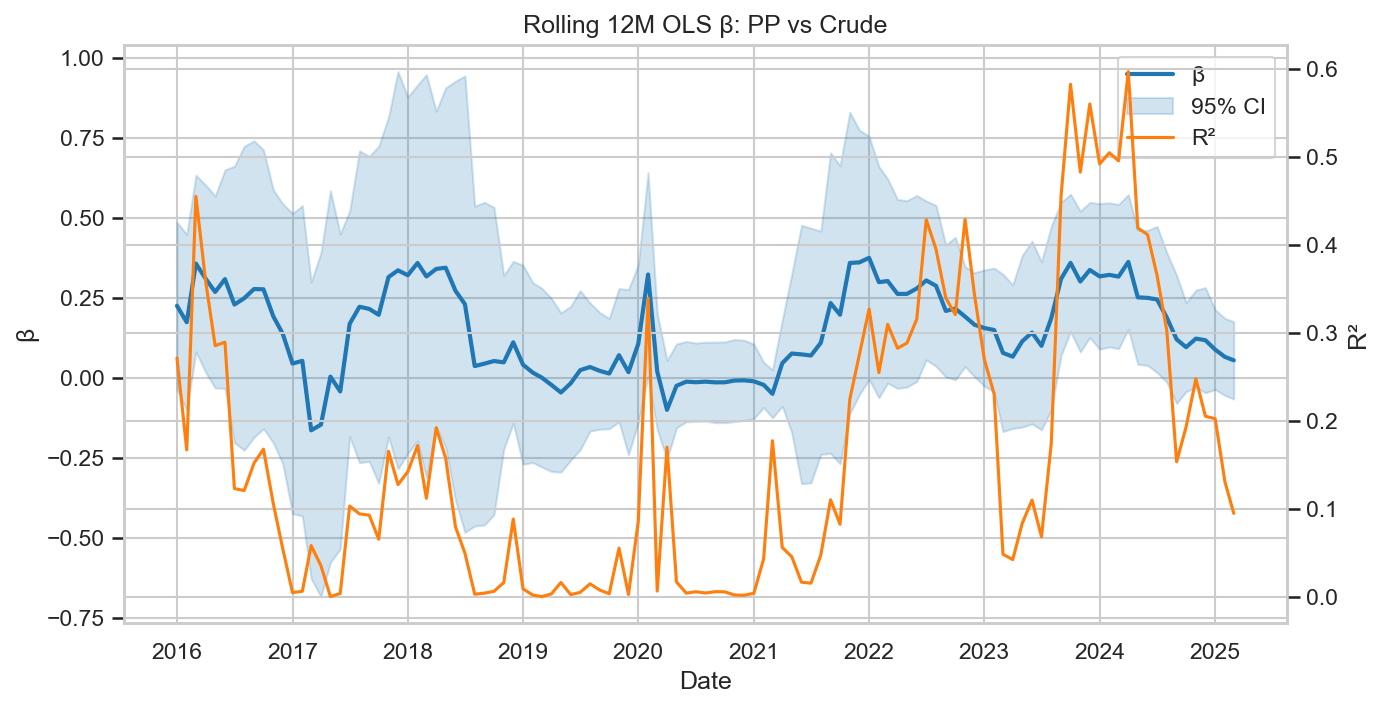

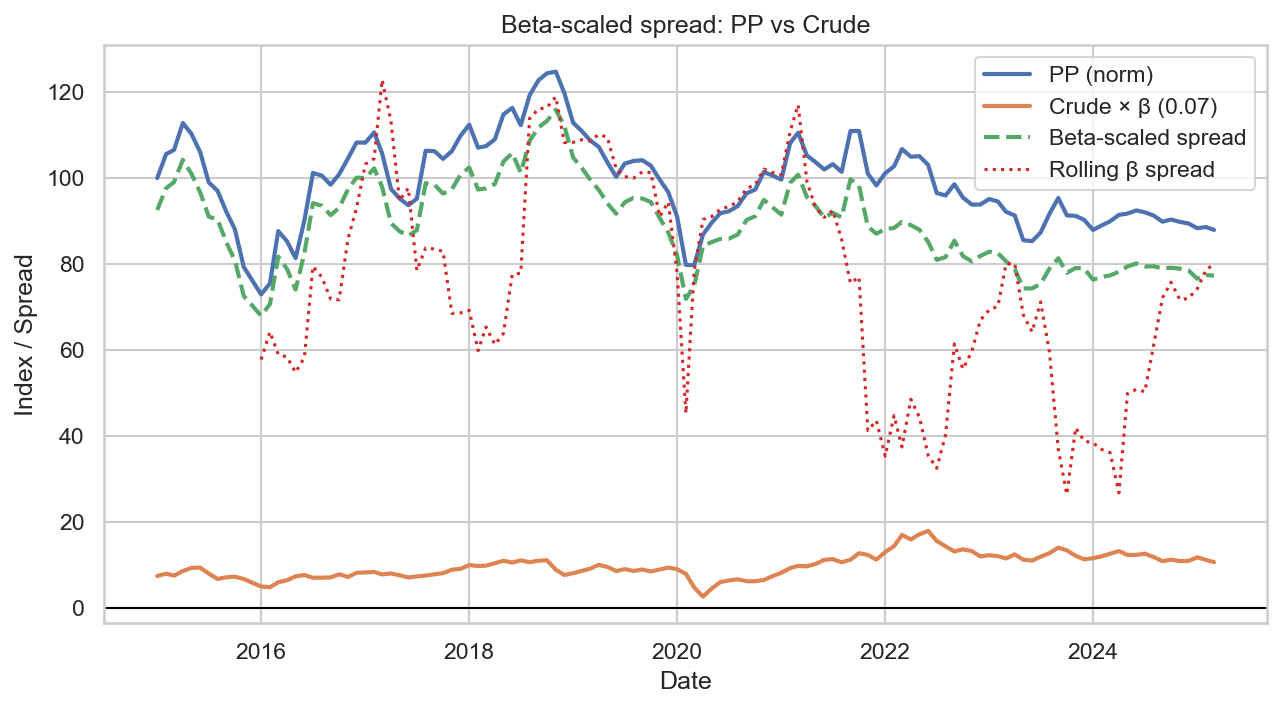

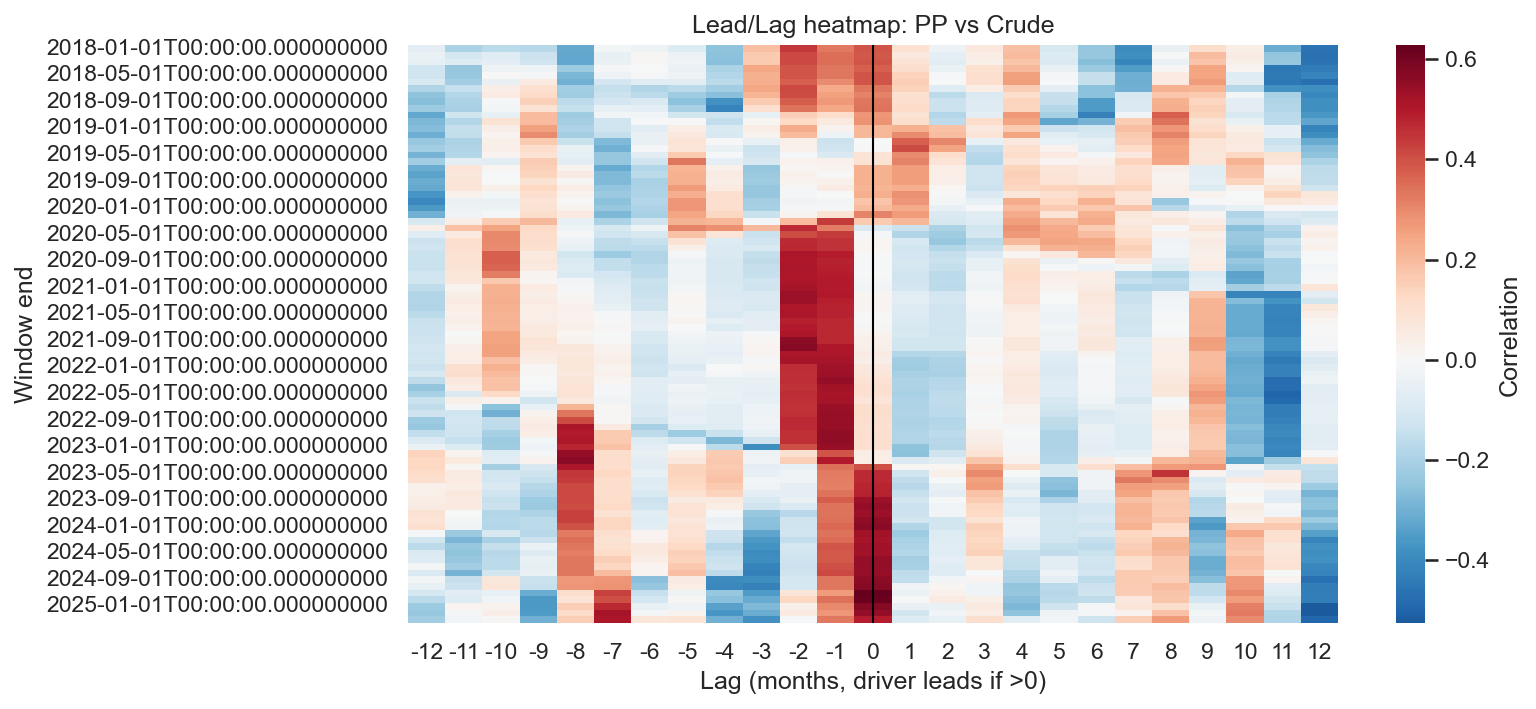

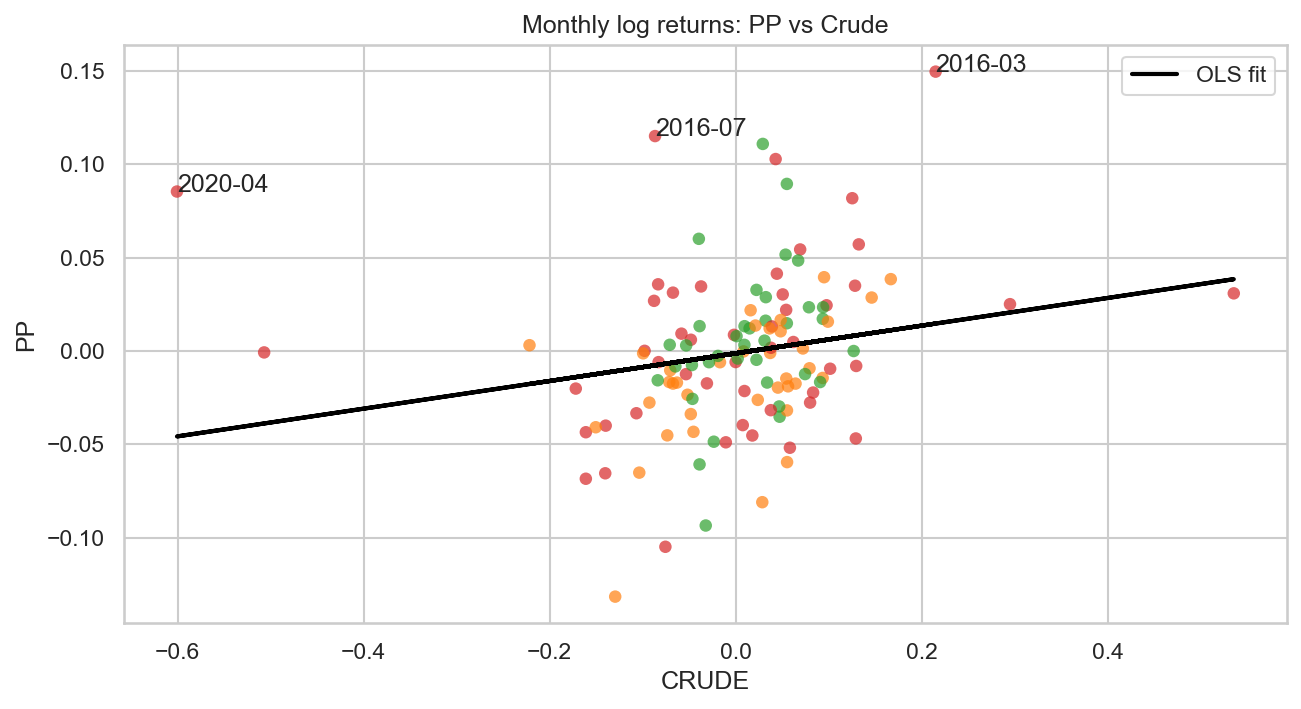

In [8]:
if {"PP", "CRUDE"} <= set(monthly_inner.columns):
    pp = monthly_inner["PP"]
    crude = monthly_inner["CRUDE"]
    pp_ret = log_returns["PP"]
    crude_ret = log_returns["CRUDE"]

    rolling_beta = rolling_beta_ols(pp_ret, crude_ret, window=12)
    if not rolling_beta.empty:
        fig = plot_rolling_beta(rolling_beta, "Rolling 12M OLS β: PP vs Crude")
        display(fig)
        fig.savefig(PLOTS_DIR / "rolling_beta_pp_crude.png", bbox_inches="tight")
        plt.close(fig)

    beta_series = rolling_beta["beta"] if "beta" in rolling_beta else None
    fig = plot_beta_scaled_spread(pp, crude, beta=None, rolling_beta=beta_series, title="Beta-scaled spread: PP vs Crude")
    display(fig)
    fig.savefig(PLOTS_DIR / "beta_scaled_spread_pp_crude.png", bbox_inches="tight")
    plt.close(fig)

    fig = plot_leadlag_heatmap(pp_ret, crude_ret, window=36, max_lag=12, title="Lead/Lag heatmap: PP vs Crude")
    display(fig)
    fig.savefig(PLOTS_DIR / "leadlag_heatmap_pp_crude.png", bbox_inches="tight")
    plt.close(fig)

    fig = plot_scatter_returns(pp_ret, crude_ret, title="Monthly log returns: PP vs Crude", label_outliers=3)
    display(fig)
    fig.savefig(PLOTS_DIR / "scatter_returns_pp_crude.png", bbox_inches="tight")
    plt.close(fig)

    rolling_corr_pp_crude = rolling_corr(pp_ret, crude_ret, window=12)
    rolling_corr_pp_crude.to_csv(ARTIFACTS_DIR / "rolling_corr_pp_crude.csv")
    corr_scan = cross_corr_scan(pp_ret, crude_ret, max_lag=12)
    corr_scan.to_csv(ARTIFACTS_DIR / "cross_corr_scan_pp_crude.csv", index=False)
else:
    display(Markdown("**Add crude data to unlock headline visuals.**"))


_Figures recap:_ Rolling β tracks relationship strength, the beta-scaled spread highlights sustained divergence, the lead/lag heatmap surfaces timing asymmetry, and the scatter pinpoints outlier months that may warrant narrative follow-up.

## Findings



In [9]:
if not monthly_inner.empty and not log_returns.empty:
    overlap = (
        monthly_inner.index.min().date(),
        monthly_inner.index.max().date(),
        len(monthly_inner),
    )
    corr_pp_crude = None
    if {"PP", "CRUDE"} <= set(log_returns.columns):
        corr_pp_crude = log_returns[["PP", "CRUDE"]].corr().iloc[0, 1]
    bullets = [
        f"- Overlap: {overlap[0]} to {overlap[1]} ({overlap[2]} months).",
        f"- PP vs Crude return correlation: {corr_pp_crude:.2f}." if corr_pp_crude is not None else "- Crude returns unavailable.",
    ]
    if Path(ARTIFACTS_DIR / "cross_corr_scan_pp_crude.csv").exists():
        scan = pd.read_csv(ARTIFACTS_DIR / "cross_corr_scan_pp_crude.csv")
        best = scan.iloc[scan["corr"].abs().idxmax()]
        bullets.append(
            f"- Best lead/lag (PP vs Crude): lag {int(best['lag'])} with corr {best['corr']:.2f}."
        )
    else:
        bullets.append("- Add drivers (PGP/crude) to compute lead/lag diagnostics.")
    display(Markdown("\n".join(bullets)))
else:
    display(Markdown("**Not enough data for findings yet.**"))


- Overlap: 2015-01-01 to 2025-03-01 (123 months).
- PP vs Crude return correlation: 0.21.
- Best lead/lag (PP vs Crude): lag -1 with corr 0.36.